<a href="https://colab.research.google.com/github/igvasilev/study-projects/blob/master/BERT_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Using BERT for NER task**
## Autor: VASILEV Igor

**Annotation** 

*Dataset*: **CoNLLpp**  https://huggingface.co/datasets/viewer/?dataset=conllpp

Based on: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/


#### Download and import libraries

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.8MB/s 
     |████████████████████████████████| 901kB 47.6MB/s 
     |████████████████████████████████| 3.3MB 51.8MB/s 


In [2]:
!pip install datasets

     |████████████████████████████████| 245kB 8.2MB/s 
     |████████████████████████████████| 245kB 43.9MB/s 
     |████████████████████████████████| 122kB 53.4MB/s 


In [3]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=65aa9de89d4250b9dc106ae6ec7ea56c48786ec5978097924968f8c7d2200a83
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"

2021-06-17 14:31:50.872907: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Downloading: 100% 629/629 [00:00<00:00, 591kB/s]
Downloading: 100% 268M/268M [00:04<00:00, 60.8MB/s]
Downloading: 100% 232k/232k [00:00<00:00, 1.82MB/s]
Downloading: 100% 48.0/48.0 [00:00<00:00, 40.6kB/s]
[{'label': 'POSITIVE', 'score': 0.9998704791069031}]


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from datasets import load_dataset

import torch
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from seqeval.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


torch.__version__


'1.8.1+cu101'

#### Download and preprocess data

In [6]:
dataset = load_dataset("conllpp")

Dataset conllpp downloaded and prepared to /root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2. Subsequent calls will reuse this data.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['chunk_tags', 'id', 'ner_tags', 'pos_tags', 'tokens'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['chunk_tags', 'id', 'ner_tags', 'pos_tags', 'tokens'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['chunk_tags', 'id', 'ner_tags', 'pos_tags', 'tokens'],
        num_rows: 3453
    })
})

In [8]:
pd.DataFrame(dataset['train']).head() 

,chunk_tags,id,ner_tags,pos_tags,tokens
0,"[11, 21, 11, 12, 21, 22, 11, 12, 0]",0,"[3, 0, 7, 0, 0, 0, 7, 0, 0]","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[EU, rejects, German, call, to, boycott, Briti..."
1,"[11, 12]",1,"[1, 2]","[22, 22]","[Peter, Blackburn]"
2,"[11, 12]",2,"[5, 0]","[22, 11]","[BRUSSELS, 1996-08-22]"
3,"[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...",3,"[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[The, European, Commission, said, on, Thursday..."
4,"[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...",4,"[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[Germany, 's, representative, to, the, Europea..."


In [9]:
id2tag = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC",
    7: "B-MISC",
    8: "I-MISC",
    9: "PAD"
    }


In [10]:
tag2id = {v:k for k,v in id2tag.items()}
tag2id

{'B-LOC': 5,
 'B-MISC': 7,
 'B-ORG': 3,
 'B-PER': 1,
 'I-LOC': 6,
 'I-MISC': 8,
 'I-ORG': 4,
 'I-PER': 2,
 'O': 0,
 'PAD': 9}

In [12]:
tag_values = [0]*10
tag_values = [id2tag[k] for k in sorted(id2tag.keys())]
tag_values

['O',
 'B-PER',
 'I-PER',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-MISC',
 'I-MISC',
 'PAD']

In [13]:
dataset['train']['tokens'][:3]

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22']]

In [14]:
tokens_train = dataset['train']['tokens']
tokens_validation = dataset['validation']['tokens']
tokens_test = dataset['test']['tokens']
tags_train = dataset['train']['ner_tags']
tags_validation = dataset['validation']['ner_tags']
tags_test = dataset['test']['ner_tags']

In [15]:
tags_train [:3]

[[3, 0, 7, 0, 0, 0, 7, 0, 0], [1, 2], [5, 0]]

#### Prepare the sentences and labels

In [16]:
MAX_LEN = 75
batch_size = 32

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [18]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [20]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [21]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(tokens_train, tags_train)
]

In [22]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [23]:
labels[:3], tokenized_texts[:3]

([[3, 0, 7, 0, 0, 0, 7, 0, 0, 0], [1, 2], [5, 5, 5, 5, 0, 0, 0, 0, 0]],
 [['EU',
   'rejects',
   'German',
   'call',
   'to',
   'boycott',
   'British',
   'la',
   '##mb',
   '.'],
  ['Peter', 'Blackburn'],
  ['BR', '##US', '##SE', '##LS', '1996', '-', '08', '-', '22']])

In [24]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [25]:
input_ids[:3]

array([[ 7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
          119,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 1943, 14428,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     

In [26]:
tags = pad_sequences([[l for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2id["PAD"], padding="post",
                     dtype="long", truncating="post")

In [27]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [28]:
def transform_data(tokens, tags):
    tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(tokens, tags)
    ]
    
    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
    
    tags = pad_sequences([[l for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2id["PAD"], padding="post",
                     dtype="long", truncating="post")

    attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
    return input_ids, tags, attention_masks

In [29]:
input_ids_val, tags_val, attention_masks_val = transform_data(tokens_validation, tags_validation)

In [30]:
input_ids_test, tags_test, attention_masks_test = transform_data(tokens_test, tags_test)

In [31]:
tr_inputs = torch.tensor(input_ids)
val_inputs = torch.tensor(input_ids_val)
test_inputs = torch.tensor(input_ids_test)

tr_tags = torch.tensor(tags)
val_tags = torch.tensor(tags_val)
test_tags = torch.tensor(tags_test)

tr_masks = torch.tensor(attention_masks)
val_masks = torch.tensor(attention_masks_val)
test_masks = torch.tensor(attention_masks_test)

In [32]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### Setup the Bert model for finetuning

In [33]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2id),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [34]:
model.cuda();

In [35]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [36]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [38]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.06110422326048204
Validation loss: 0.06403093113861841
Validation Accuracy: 0.9826139709690307



Epoch:  33%|███▎      | 1/3 [03:18<06:37, 198.66s/it]

Validation F1-Score: 0.928236989014947

Average train loss: 0.034321320666146626
Validation loss: 0.06152069701655658
Validation Accuracy: 0.9837089208824704



Epoch:  67%|██████▋   | 2/3 [06:45<03:20, 200.99s/it]

Validation F1-Score: 0.933777517669833

Average train loss: 0.026358285766086436
Validation loss: 0.06152069701655658
Validation Accuracy: 0.9837089208824704



Epoch: 100%|██████████| 3/3 [10:11<00:00, 203.78s/it]

Validation F1-Score: 0.933777517669833



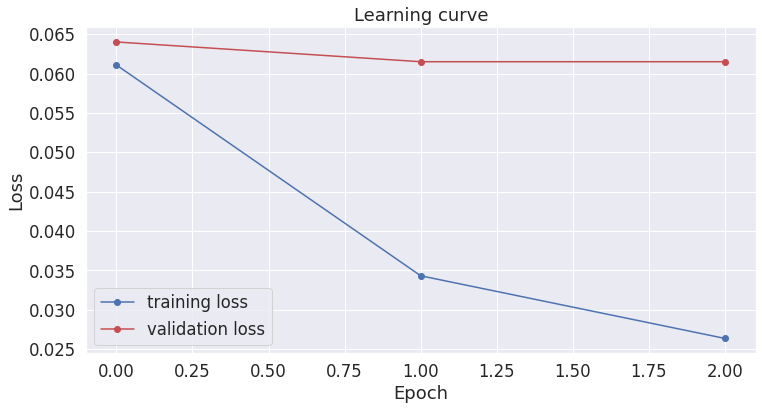

In [39]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Test

In [41]:
test_loss_values = []
TEST = True
if TEST:
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(test_dataloader)
    test_loss_values.append(eval_loss)
    print("Test loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Test Accuracy: {}".format(accuracy_score(pred_tags, test_tags)))
    print("Test F1-Score: {}".format(f1_score([pred_tags], [test_tags])))
    print()

Test loss: 0.12853468922548927
Test Accuracy: 0.9709518608222127
Test F1-Score: 0.8991743119266055

